In [1]:
#default_exp core

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from nbdev.showdoc import *

In [4]:
#export
from fastai2.basics import *

In [51]:
#export
from timeseries.data import *
from timeseries.models.inception_time import *

In [6]:
#export
from fastai2.vision.data import get_grid
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.optimizer import *
from fastai2.callback.hook import *
from fastai2.callback.schedule import *
from fastai2.callback.progress import *
# from fastai2.callback.mixup import *

In [7]:
#export
def test_eq_tensor(a,b):
    "assert tensor equality"
    assert (a-b).pow(2).sum() <= 1e-10, f"{a}\n{b}"

In [8]:
#export
class TensorTS(TensorBase):
    "Transform a 2D array into a Tensor"
#     def __rep__(): return f"{self.__class__.__name__}\n {self.shape}"
    def show(self, ctx=None, title=None, chs=None, leg=True, **kwargs):
        "Display timeseries plots for all selected channels list `chs`"
        if ctx is None: fig, ctx = plt.subplots()
        t = range(self.shape[1])
        chs_max = max(chs) if chs else 0
        channels = chs if (chs and (chs_max < self.shape[0])) else range(self.shape[0])
        for ch in channels:
            ctx.plot(t, self[ch], label='ch'+str(ch))
        if leg: ctx.legend(loc='upper right', ncol=2, framealpha=0.5)
        if title: ctx.set_title(title)

In [9]:
#export
class ToTensorTSBlock(Transform):
    "x : 2D numpy array"
    def encodes(self, x):
        return TensorTS(x)

In [10]:
#export
class ToTensorTS(Transform):
    "x : tuple representing (2D numpy array, Label)"
    def encodes(self, x):
        return TensorTS(x[0])

In [11]:
#export
class LabelTS(Transform):
    "x : tuple representing (2D numpy array, Label)"
    def encodes(self, x):
        return x[1]

In [12]:
def get_stats(train, scale_type='standardize', scale_subtype='all_samples'):
    "get_stats is only needed when we want to normalize timeseries tensors using ALL SAMPLES statistics"
    "For SINGLE SAMPLE normalize (standardize), please check out both `class Normalize` and `class Standardize`"
    "Exampe NATOPS => shape = [360, 24, 51]"

    "returns a tensor of a shape of [n_channels, sequence_length]. For NATOPS it is [24, 51]"
    "This way is more effectient because we do not need to broadcast every time when we will normalize (scale) a timeseries tensor"
    if len(train) <= 0:
        return None,None
    else:
        n_channels = train[0].shape[0]
        sequence_length = train[0].shape[1]
        # print(x.shape, sequence_length)
    
    if scale_type == 'normalize':
        # 'all_samples' => returns (mean , std) as scalars
        if scale_subtype == 'all_samples':
            train_min = train.min()
            train_max = train.max()
            min = torch.tensor(train_min).expand(n_channels, sequence_length) 
            max = torch.tensor(train_max).expand(n_channels, sequence_length)
        # 'per_channel' => returns (mean , std) with each a shape = [n_channels] => For NATOPS [24]
        elif scale_subtype == 'all_samples_per_channel':
            train_min = train.min(axis=(0, 2))
            train_max = train.max(axis=(0, 2))
            min = torch.tensor(train_min).unsqueeze(1).repeat(1, sequence_length) 
            max = torch.tensor(train_max).unsqueeze(1).repeat(1, sequence_length)
        else:
            print(f'In {scale_type} : ***** Please, select a valid  scale_subtype ***** - You passed : {scale_subtype}')
            return None,None
        # returns a tensor of a shape of [n_channels, sequence_length]. For NATOPS it's [24, 51]
        # This way is more effectient because we do not need to broadcast every time we normalize (scale) a timeseries tensor
        return min, max

    #Exampe NATOPS => shape = [360, 24, 51]
    elif scale_type == 'standardize':
        print(scale_type)
        # 'all_samples' => returns (mean , std) as scalars
        if scale_subtype == 'all_samples':
            train_mean = train.mean()
            train_std = train.std()
            mean = torch.tensor(train_mean).expand(n_channels, sequence_length) 
            std  = torch.tensor(train_std).expand(n_channels, sequence_length)
        # 'per_channel' => returns (mean , std) with each a shape = [n_channels] => For NATOPS [24]
        elif scale_subtype == 'all_samples_per_channel':
            train_mean = train.mean(axis=(0, 2))
            train_std = train.std(axis=(0, 2))
            mean = torch.tensor(train_mean).unsqueeze(1).repeat(1, sequence_length) 
            std  = torch.tensor(train_std).unsqueeze(1).repeat(1, sequence_length)
        else:
            print(f'In {scale_type} : ***** Please, select a valid  scale_subtype ***** - You passed : {scale_subtype}')
            return None,None
        return mean, std 

    else:
        print('***** Please, select a valid  scaling_type *****')
        return None,None

In [13]:
#export
def get_min_max(train, scale_subtype='all_samples'):
    "get_mean_std is only needed when we want to normalize timeseries tensors using ALL SAMPLES statistics"
    "For SINGLE SAMPLE normalization (Standardization), please check out both `class Normalize` and `class Standardize`"
    "Exampe NATOPS => shape = [360, 24, 51]"

    "returns a tensor of a shape of [n_channels, sequence_length]. For NATOPS it is [24, 51]"
    "This way is more effectient because we do not need to broadcast every time when we will normalize (scale) a timeseries tensor"
    if len(train) <= 0:
        return None,None
    else:
        n_channels = train[0].shape[0]
        sequence_length = train[0].shape[1]
    
    #Exampe NATOPS => shape = [360, 24, 51]
    # 'all_samples' => returns (mean , std) as scalars
    if scale_subtype == 'all_samples':
        train_min = train.min()
        train_max = train.max()
        min = torch.tensor(train_min).expand(n_channels, sequence_length) 
        max = torch.tensor(train_max).expand(n_channels, sequence_length)
    # 'per_channel' => returns (mean , std) with each a shape = [n_channels] => For NATOPS [24]
    elif scale_subtype == 'all_samples_per_channel':
        train_min = train.min(axis=(0, 2))
        train_max = train.max(axis=(0, 2))
        min = torch.tensor(train_min).unsqueeze(1).repeat(1, sequence_length) 
        max = torch.tensor(train_max).unsqueeze(1).repeat(1, sequence_length)
    else:
        print(f'In {scale_type} : ***** Please, select a valid  scale_subtype ***** - You passed : {scale_subtype}')
        return None,None
    # returns a tensor of a shape of [n_channels, sequence_length]. For NATOPS it's [24, 51]
    # This way is more effectient because we do not need to broadcast every time we normalize (scale) a timeseries tensor
    return min, max

In [15]:
#export
def get_mean_std(train, scale_subtype='all_samples'):
    "get_mean_std is only needed when we want to normalize timeseries tensors using ALL SAMPLES statistics"
    "For SINGLE SAMPLE normalization (Standardization), please check out both `class Normalize` and `class Standardize`"
    "Exampe NATOPS => shape = [360, 24, 51]"

    "returns a tensor of a shape of [n_channels, sequence_length]. For NATOPS it is [24, 51]"
    "This way is more effectient because we do not need to broadcast every time when we will normalize (scale) a timeseries tensor"
    if len(train) <= 0:
        return None,None
    else:
        n_channels = train[0].shape[0]
        sequence_length = train[0].shape[1]
        # print(x.shape, sequence_length)
    
    #Exampe NATOPS => shape = [360, 24, 51]
    # 'all_samples' => returns (mean , std) as scalars
    if scale_subtype == 'all_samples':
        train_mean = train.mean()
        train_std = train.std()
        mean = torch.tensor(train_mean).expand(n_channels, sequence_length) 
        std  = torch.tensor(train_std).expand(n_channels, sequence_length)
    # 'per_channel' => returns (mean , std) with each a shape = [n_channels] => For NATOPS [24]
    elif scale_subtype == 'all_samples_per_channel':
        train_mean = train.mean(axis=(0, 2))
        train_std = train.std(axis=(0, 2))
        mean = torch.tensor(train_mean).unsqueeze(1).repeat(1, sequence_length) 
        std  = torch.tensor(train_std).unsqueeze(1).repeat(1, sequence_length)
    else:
        print(f'In {scale_type} : ***** Please, select a valid  scale_subtype ***** - You passed : {scale_subtype}')
        return None,None
    return mean, std 

## Normalize Transform

In [16]:
#export
@docs
class Standardize(Transform):
    "In Timerseries Lingo, Standardize means normalize the timeseries (counter-intuitive)"
    "Scale timeserie x `TensorTS` using the mean and standard deviation"
    order=99
    def __init__(self, mean=None, std=None, scale_subtype='per_sample', cuda=True): 
        self.scale_subtype = scale_subtype
        
        f = to_device if cuda else noop
        if mean is not None: 
            self.mean = f(mean) 
        if std is not None: 
           self.std = f(std)       
    
    # 'all_samples' => returns (mean , std) with each a shape = [1, 1, 1]
    # 'per_channel' => returns (mean , std) with each a shape = [1, 24, 1]

    def encodes(self, x:TensorTS): 
        #print('Standardize - encodes')
        # if self.scale_subtype == 'per_sample' or per_sample_per_channel, compute (mean, std) of the current x:TensorTS (sample)
        if self.scale_subtype == 'per_sample':
            self.mean = x.mean(axis=(0,1), keepdims=True)
            self.std = x.std(axis=(0,1), keepdims=True) # + 1e-7 like fastai
        elif self.scale_subtype == 'per_sample_per_channel':
            # print('per_sample_per_channel')
            self.mean = x.mean(axis=(1), keepdims=True)
            self.std = x.std(axis=(1), keepdims=True)  # + 1e-7 like fastai
        return (x-self.mean) / self.std

    def decodes(self, x:TensorTS): 
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std) + f(self.mean))

    _docs=dict(encodes="Scale timeserie x `TensorTS` using the mean and standard deviation", 
    decodes="Reverse the scaling transform. Get the orignal timeserie values")

In [17]:
#export
@docs
class Normalize(Transform):
    "In Timerseries Lingo, Normalize means scale the timeseries (counter-intuitive) between its min and max values"
    "Scale timeserie x `TensorTS` using the min and max values"
    order=99
    def __init__(self, min=None, max=None, scale_subtype='per_sample', scale_range=(-1, 1), cuda=True): 
        self.scale_subtype = scale_subtype
        self.scale_range = scale_range
        f = to_device if cuda else noop
        if min is not None: 
            self.min = f(min) 
        if max is not None: 
           self.max = f(max)       
    
    # 'all_samples' => returns (min , max) with each a shape = [1, 1, 1]
    # 'per_channel' => returns (min , max) with each a shape = [1, 24, 1]
    def encodes(self, x:TensorTS): 
        #print('Standardize - encodes')
        # if self.scale_subtype == 'per_sample' or per_sample_per_channel, compute (min, max) of the current x:TensorTS (sample)
        if self.scale_subtype == 'per_sample':
            self.min = TensorTS((torch.min(x)).expand_as(x))
            self.max = TensorTS((torch.max(x)).expand_as(x))
            # self.min = x.min(axis=(0,1), keepdim=True).values
            # self.max = x.max(axis=(0,1), keepdim=True).values
        elif self.scale_subtype == 'per_sample_per_channel':
#           print('per_sample_per_channel')
            # self.min = TensorTS(x.min(axis=(1), keepdims=True).values)
            # self.max = TensorTS(x.max(axis=(1), keepdims=True).values)
            self.min = TensorTS(torch.min(x, dim=1, keepdims=True).values)
            self.max = TensorTS(torch.max(x, dim=1, keepdims=True).values)
        return ((x-self.min)/(self.max - self.min))*(self.scale_range[1] - self.scale_range[0]) + self.scale_range[0]
        
    
    def decodes(self, x:TensorTS): 
        f = to_cpu if x.device.type=='cpu' else noop
        x_orig = ((x-self.scale_range[0])/(self.scale_range[1] - self.scale_range[0]))*(self.max - self.min) + self.min
        return f(x_orig)

    _docs=dict(encodes="Scale timeserie x `TensorTS` using the min and max values", 
    decodes="Reverse the scaling transform. Get the orignal timeserie values")

In [18]:
#export
def TSBlock():
    "`TransformBlock` for timeseries : Transform np array to TensorTS type"
    return TransformBlock(type_tfms=ToTensorTSBlock())

In [19]:
#export
def default_show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
    ctxs = [b[0].show(ctx=c, title=b[1], **kwargs) for b,c,_ in zip(samples,ctxs,range(max_n))]
    plt.tight_layout()
    return ctxs

In [20]:
#export
@typedispatch
def show_batch(x:TensorTS, y, samples, ctxs=None, max_n=9, rows=None, cols=None, figsize=None, title=None, **kwargs):
    if ctxs is None: ctxs = get_grid(max_n, rows=rows, cols=cols, figsize=figsize)

    ctxs = default_show_batch(x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    if title:
        plt.suptitle(title, fontsize=16)
        plt.subplots_adjust()
        plt.subplots_adjust(left=0.0, wspace=0.4, top=0.9, bottom=0.5)
    return ctxs

In [21]:
#export
@typedispatch
def show_results(x:TensorTS, y, samples,  outs, ctxs=None, max_n=9, rows=None, cols=None, figsize=None, **kwargs):
    # if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    s = len(samples)  # min(len(samples), max_n)
    # max_n = min(s, max_n)
    if ctxs is None: ctxs = get_grid(max_n, rows=rows, cols=cols, add_vert=1, figsize=figsize)
    # print(len(samples), max_n)
    # print(samples)
    # print(type(y))
    # outs = [('6.0',),('2.0',)]
    outs = [detuplify(o) for o in outs]
    # outs = ['6.0', '2.0']

    ctxs = [b[0].show(ctx=c, title=f'{o} / {b[1]}', **kwargs) for b,o,c,_ in zip(samples,outs,ctxs,range(max_n))]
    # if title:
    #     plt.suptitle(title, fontsize=16)
    #     plt.subplots_adjust(left=0.0, wspace=0.4, top=0.9)
    plt.tight_layout()
    return ctxs

# Example

In [22]:
# path_data = Config().data
# path_data, path_data.ls()

In [23]:
dsname =  'NATOPS' #'NATOPS', 'LSST', 'Wine', 'Epilepsy', 'HandMovementDirection'

In [24]:
path = download_unzip_data_UCR(dsname=dsname)
path, path.ls()

(Path('C:/Users/fh/.fastai/data/NATOPS'),
 (#55) [Path('C:/Users/fh/.fastai/data/NATOPS/models'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS.jpg'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS.txt'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension10_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension10_TRAIN.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension11_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension11_TRAIN.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension12_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension12_TRAIN.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension13_TEST.arff')...])

In [25]:
fname_train = f'{dsname}_Train.arff'
fname_test = f'{dsname}_Test.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.arff'),
 Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Test.arff')]

In [26]:
data = TSData()
train_x, train_y = data.load(fnames)
print(data)

TSData:
 Datasets names (concatenated): ['NATOPS_Train', 'NATOPS_Test']
 Filenames:                     [Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.arff'), Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Test.arff')]
 Data shape: (360, 24, 51)
 Targets shape: (360,)
 Nb Samples: 360
 Nb Channels:           24
 Sequence Length: 51


In [27]:
# returns tuples
items = data.get_items()
idx=0
items[idx]

(array([[-0.372758, -0.367844, -0.378445, ..., -0.537007, -0.475939,
         -0.479505],
        [-1.821679, -1.841987, -1.821358, ..., -1.751323, -1.772353,
         -1.761632],
        [-0.846321, -0.846325, -0.839571, ..., -0.60374 , -0.763048,
         -0.793202],
        ...,
        [ 0.619205,  0.617045,  0.624789, ...,  0.541325,  0.559272,
          0.571569],
        [-1.771773, -1.79666 , -1.738568, ..., -1.691657, -1.683121,
         -1.721661],
        [-0.810086, -0.818863, -0.78806 , ..., -0.716364, -0.757526,
         -0.741532]], dtype=float32), '4.0')

In [28]:
seed = 42
splits = RandomSplitter(seed=seed)(range_of(items))
splits
# len(split_idx[0]), len(split_idx[1])

((#288) [304,281,114,329,115,130,338,294,94,310...],
 (#72) [222,27,96,253,274,35,160,172,302,146...])

# Using `Datasets`

In [29]:
tfm_norm = Normalize(scale_subtype = 'per_sample', scale_range=(0, 1))
# tfm_norm = Standardize(scale_subtype = 'per_sample')
 
tfms = [[ToTensorTS(as_item=True)], [LabelTS(as_item=True), Categorize()]]
# Create a dataset
ds = Datasets(items, tfms, splits=splits)

In [30]:
ds[0][0].shape[0]

24

3.0


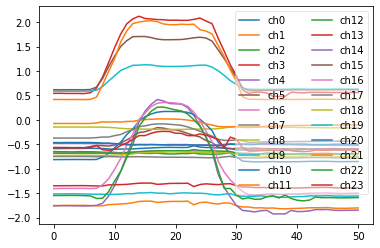

In [31]:
ax = show_at(ds, 2, figsize=(1,1))

# Data Normalization

## `ALL SAMPLES statistics`

## Mean and Standard Deviation for `all_samples` or `all_samples_per_channel`

In [ ]:
scale_subtype = 'all_samples'
# scale_subtype = 'all_samples_per_channel'
mean, std = get_mean_std(data.x, scale_subtype=scale_subtype)
mean.shape, std.shape, mean, std

## Min and Max for `all_samples` or `all_samples_per_channel`

In [ ]:
scale_subtype = 'all_samples_per_channel' #'all_samples_per_channel'      # 'all_samples', 'all_samples_per_channel'
min, max = get_min_max(data.x, scale_subtype=scale_subtype)
min.shape, max.shape, min, max

## Prepare `TenssorTS` item to use for normalization tests

In [ ]:
idx = 3
item = items[idx]
item

(TensorTS([[-0.5147, -0.5186, -0.5213,  ..., -0.6287, -0.6326, -0.6065],
         [-1.8940, -1.8950, -1.8920,  ..., -1.9529, -1.9495, -1.9313],
         [-0.7490, -0.7383, -0.7287,  ..., -0.6161, -0.6443, -0.6673],
         ...,
         [ 0.4397,  0.4380,  0.4334,  ...,  0.5668,  0.5064,  0.5925],
         [-1.7014, -1.7506, -1.6242,  ..., -1.6601, -1.9693, -1.6339],
         [-0.8094, -0.8248, -0.7892,  ..., -0.5281, -0.4773, -0.5100]]),
 torch.Size([24, 51]),
 None)

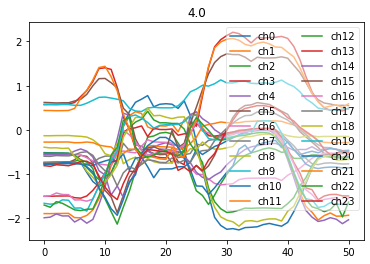

In [38]:
tfm_tts = ToTensorTS(as_item=True)
t = tfm_tts(item)
t, t.shape, t.show(title=item[1])

## Test All the Normalization types

In [39]:
tfm_norm = Normalize(min=min, max=max, scale_subtype = 'all_samples', scale_range=(0, 1), cuda=False)
item_norm = tfm_norm(t)
test_eq_tensor(t, tfm_norm.decodes(item_norm))

In [40]:
tfm_norm = Normalize(min=min, max=max, scale_subtype = 'all_samples_per_channel', scale_range=(0, 1), cuda=False)
item_norm = tfm_norm(t)
test_eq_tensor(t, tfm_norm.decodes(item_norm))

In [41]:
# tfm_norm = Normalize(min=min, max=max, scale_subtype = 'per_sample_per_channel', scale_range=(0, 1), cuda=False)
tfm_norm = Normalize(scale_subtype = 'per_sample', scale_range=(0, 1), cuda=False)
item_norm = tfm_norm(t)
test_eq_tensor(t, tfm_norm.decodes(item_norm))

In [42]:
tfm_norm = Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1), cuda=False)
item_norm = tfm_norm(t)
test_eq_tensor(t, tfm_norm.decodes(item_norm))

## Test All the Standardization types

In [43]:
tfm_norm = Standardize(mean=mean, std=std, scale_subtype = 'all_samples', cuda=False)
item_norm = tfm_norm(t)
test_eq_tensor(t, tfm_norm.decodes(item_norm))

In [44]:
tfm_norm = Standardize(mean=mean, std=std, scale_subtype = 'all_samples_per_channel', cuda=False)
item_norm = tfm_norm(t)
test_eq_tensor(t, tfm_norm.decodes(item_norm))

In [45]:
tfm_norm = Standardize(scale_subtype = 'per_sample', cuda=False)
item_norm = tfm_norm(t)
test_eq_tensor(t, tfm_norm.decodes(item_norm))

In [46]:
tfm_norm = Standardize(scale_subtype = 'per_sample_per_channel', cuda=False)
item_norm = tfm_norm(t)
test_eq_tensor(t, tfm_norm.decodes(item_norm))

## Create dataloaders objects using Using `Datasets.dataloaders`

In [32]:
bs = 128                            
# Normalize (at batch time) means scale using min and max
batch_tfms = [Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1))]
# batch_tfms = [Standardize(scale_subtype = 'per_sample_per_channel')]

dls1 = ds.dataloaders( bs=bs, val_bs=bs * 2, after_batch=batch_tfms, num_workers=0, device=default_device()) 

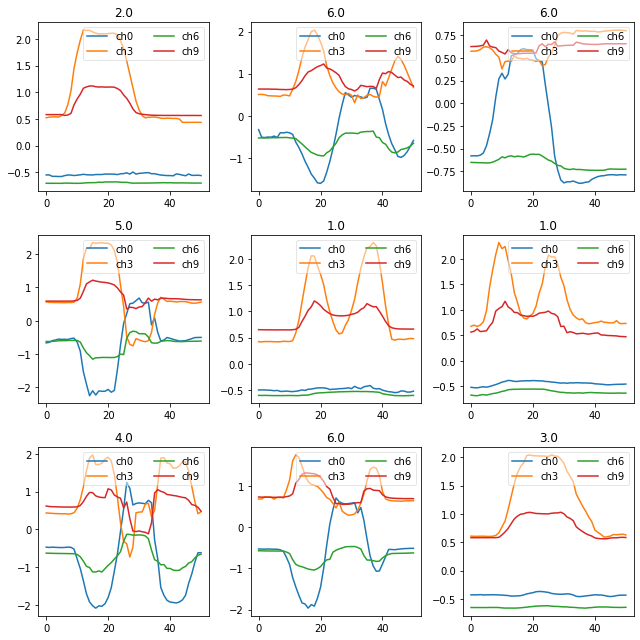

In [33]:
dls1.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

# Using `Datablock`

## First method : supply get_items() method

In [34]:
tsdb = DataBlock(blocks=(TSBlock, CategoryBlock),
                   get_items=get_ts_items,
                   get_x=lambda x:x[0],
                   splitter=RandomSplitter(seed=seed),
                   get_y=lambda x:x[1],
                   batch_tfms = batch_tfms)

## Test DataBlock

In [35]:
test_eq(tsdb.type_tfms[0].map(type), [ToTensorTSBlock])
test_eq(tsdb.type_tfms[1].map(type), [Categorize])
test_eq(tsdb.default_item_tfms.map(type), [ToTensor])
test_eq(tsdb.batch_tfms.map(type), [Normalize])

## Summary

In [36]:
# fnames = [path/fname_train, path/fname_test]
tsdb.summary(fnames)

Setting-up type transforms pipelines
Found 360 items
2 datasets of sizes 288,72
Setting up Pipeline: <lambda> -> ToTensorTSBlock
Setting up Pipeline: <lambda> -> Categorize

Building one sample
  Pipeline: <lambda> -> ToTensorTSBlock
    starting from
      ([[-0.540579 -0.54101  -0.540603 ... -0.56305  -0.566314 -0.553712]
 [-1.539567 -1.540042 -1.538992 ... -1.532014 -1.534645 -1.536015]
 [-0.608539 -0.604609 -0.607679 ... -0.593769 -0.592854 -0.599014]
 ...
 [ 0.454542  0.449924  0.453195 ...  0.480281  0.45537   0.457275]
 [-1.411445 -1.363464 -1.390869 ... -1.468123 -1.368706 -1.386574]
 [-0.473406 -0.453322 -0.463813 ... -0.440582 -0.427211 -0.435581]], 2.0)
    applying <lambda> gives
      [[-0.540579 -0.54101  -0.540603 ... -0.56305  -0.566314 -0.553712]
 [-1.539567 -1.540042 -1.538992 ... -1.532014 -1.534645 -1.536015]
 [-0.608539 -0.604609 -0.607679 ... -0.593769 -0.592854 -0.599014]
 ...
 [ 0.454542  0.449924  0.453195 ...  0.480281  0.45537   0.457275]
 [-1.411445 -1.36346

In [37]:
dls2 = tsdb.dataloaders(fnames, num_workers=0, device=default_device())

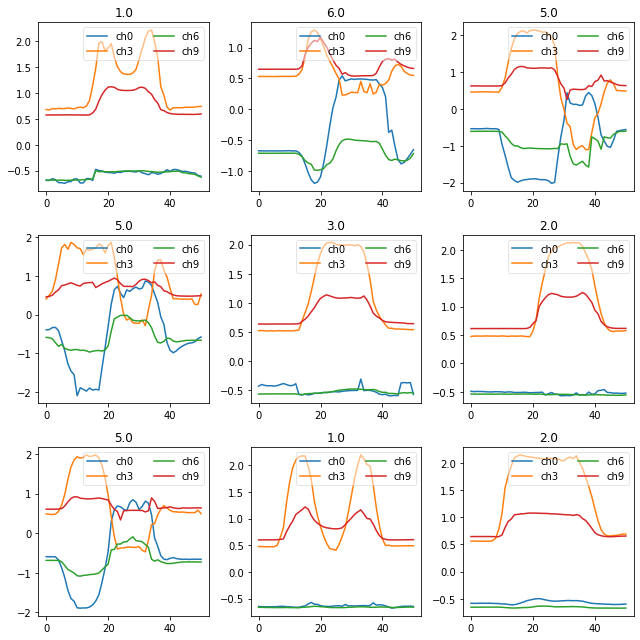

In [38]:
dls2.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

## Second method : Providing items object as an argument to the `DataBlock.dataloaders()` method

In [39]:
tsdb = DataBlock(blocks=(TSBlock, CategoryBlock),
                   get_x=lambda x:x[0],
                   splitter=RandomSplitter(seed=seed),
                   get_y=lambda x:x[1])

In [40]:
# Using data.get_items()
#dls_2 = tsdb_2.dataloaders(data.get_items(), batch_tfms=batch_tfms, num_workers=0, device=default_device())

# Or using get_ts_items([fname_train, fname_test])
dls3 = tsdb.dataloaders(get_ts_items(fnames), batch_tfms=batch_tfms, num_workers=0, device=default_device())

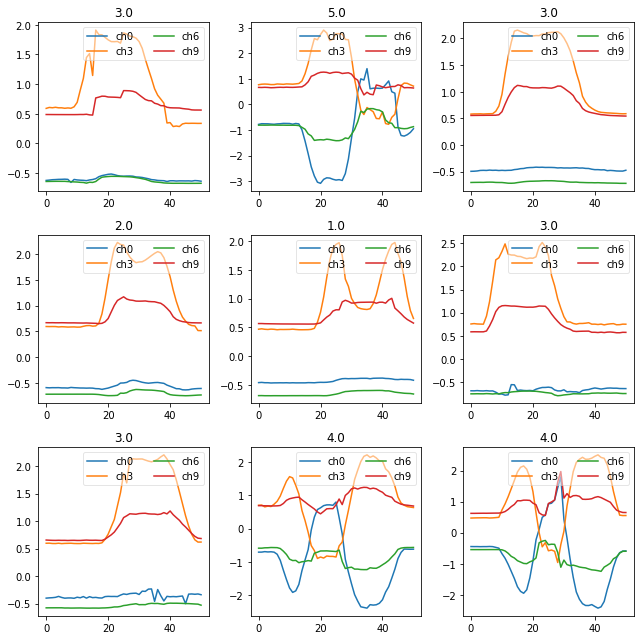

In [41]:
dls3.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

# Define `TSDataLoaders`

In [42]:
#export
class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_files(cls, fnames,  path='.', valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create timeseries dataloaders from a list of timeseries files in `fnames` in `path`."
        dblock = DataBlock(blocks=(TSBlock, CategoryBlock),
                           get_items=get_ts_items,
                           get_x=lambda x:x[0],
                           splitter=RandomSplitter(seed=seed),
                            get_y=lambda x:x[1],
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        
        return cls.from_dblock(dblock, fnames, path, **kwargs)

In [43]:
show_doc(TSDataLoaders.from_files)

<h4 id="TSDataLoaders.from_files" class="doc_header"><code>TSDataLoaders.from_files</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>TSDataLoaders.from_files</code>(**`fnames`**, **`path`**=*`'.'`*, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create timeseries dataloaders from a list of timeseries files in `fnames` in `path`.

In [44]:
# fnames = [path/fname_train, path/fname_test]
dls4 = TSDataLoaders.from_files(fnames=fnames, path=path, batch_tfms=batch_tfms, num_workers=0, device=default_device())

In [45]:
dls4.path

Path('C:/Users/fh/.fastai/data/NATOPS')

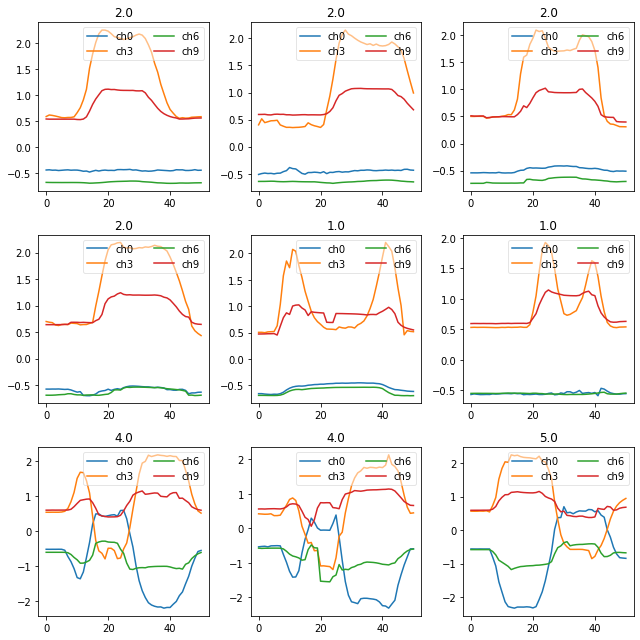

In [46]:
dls4.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

# Train Model

In [47]:
# export
def get_n_channels(dl: DataLoader):
    return dl.dataset[0][0].shape[0]

In [49]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = get_n_channels(dls4.train) # data.n_channels
# Number of classes
c_out= len(dls4.vocab) 
c_in,c_out

(24, 6)

## Create model

In [52]:
model = inception_time(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(24, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(24, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(24, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(24, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39

In [53]:
# model[5]

## Build learner

In [54]:
#Learner
opt_func = partial(Adam, lr=3e-3, wd=0.01)     
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls4, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

## Learner Summary

In [55]:
print(learn.summary())

Sequential (Input shape: ['64 x 24 x 51'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 51         29,952     True      
________________________________________________________________
Conv1d               64 x 32 x 51         14,592     True      
________________________________________________________________
Conv1d               64 x 32 x 51         6,912      True      
________________________________________________________________
MaxPool1d            64 x 24 x 51         0          False     
________________________________________________________________
Conv1d               64 x 32 x 51         768        True      
________________________________________________________________
BatchNorm1d          64 x 128 x 51        256        True      
________________________________________________________________
ReLU                 64 x 128 x 51        0          False     
_______________________________________________________

## LR finder

(0.014454397559165954, 0.00019054606673307717)

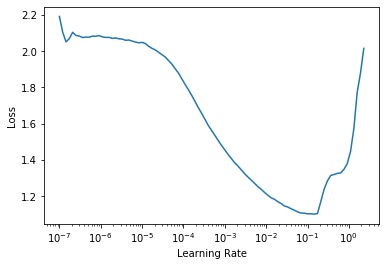

In [56]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

## Train

In [57]:
# learn.fit_one_cycle(20, lr_max=lr_steep)
lr_max = 1e-3
epochs = 20; lr_max = lr_steep;  pct_start = .7; moms=(0.95,0.85,0.95); wd = 1e-2
learn.fit_one_cycle(epochs, lr_max=lr_max, pct_start=pct_start,  moms=moms, wd=wd)
learn.save('stage_1')

epoch,train_loss,valid_loss,accuracy,time
0,2.089482,1.790290,0.222222,00:00
1,2.014370,1.789341,0.152778,00:00
2,1.928314,1.791671,0.263889,00:00
3,1.818767,1.797760,0.222222,00:00
4,1.690616,1.805189,0.222222,00:00
5,1.558504,1.808904,0.222222,00:00
6,1.431750,1.795830,0.222222,00:00
7,1.318972,1.720285,0.250000,00:00
8,1.217711,1.532382,0.513889,00:00
9,1.133390,1.239371,0.666667,00:00


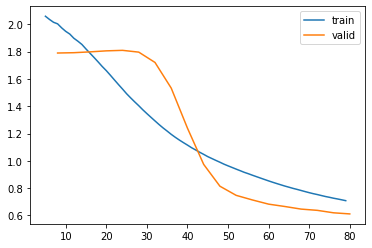

In [58]:
learn.recorder.plot_loss()

## Show results

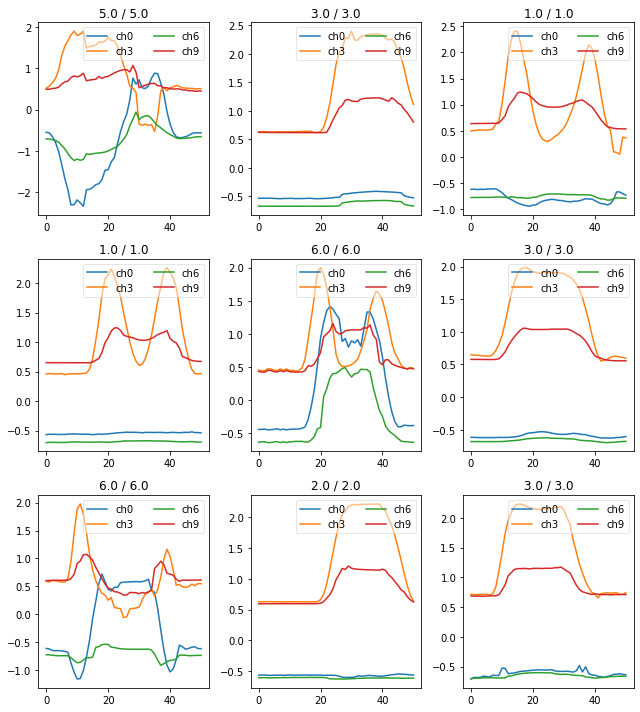

In [59]:
learn.show_results(max_n=9, chs=range(0,12,3))

## Export -

In [60]:
#hide
from nbdev.export import notebook2script
notebook2script()
# notebook2script(fname='81_timeseries_core.ipynb')

Converted 80_timeseries_data.ipynb.
Converted 81_timeseries_core.ipynb.
Converted index.ipynb.


In [86]:
#hide
from nbdev.export2html import _notebook2html
# notebook2script()
_notebook2html(fname='81_timeseries_core.ipynb')

converting: 81_timeseries_core.ipynb
'charmap' codec can't encode character '\u2212' in position 43353: character maps to <undefined>


False